# <center><ins>Analyzing relationship between Birdstrikes and Weather</ins><center>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import requests
import json
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from itertools import combinations

In [106]:
df_cleaned = pd.read_csv('Datasets/df_cleaned.csv')

In [107]:
df_cleaned.head()

,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Airport ID,Airport,State,Flight Phase,Visibility,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact
0,2010,1,1,BUS,BUSINESS,C-310,KPMP,POMPANO BEACH AIRPARK,FL,TAKEOFF RUN,DAY,0.0,30.0,0.0,NE1,GULL,1,ABORTED TAKEOFF
1,2010,1,1,JBU,JETBLUE AIRWAYS,A-320,KMCO,ORLANDO INTL,FL,TAKEOFF RUN,DAY,0.0,120.0,0.0,ZT3,GRACKLE,1,NONE
2,2010,1,2,SKW,SKYWEST AIRLINES,CRJ100/200,KSLC,SALT LAKE CITY INTL,UT,LANDING ROLL,DAY,0.0,80.0,0.0,YH004,HORNED LARK,1,NONE
3,2010,1,2,NWA,NORTHWEST AIRLINES,DC-9,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,MD,TAKEOFF RUN,DAY,0.0,140.0,0.0,K33,HAWK,1,NONE
4,2010,1,2,JBU,JETBLUE AIRWAYS,A-320,KMCO,ORLANDO INTL,FL,APPROACH,DAY,20.0,120.0,0.0,YI010,TREE SWALLOW,1,NONE


**Count of Incidents at each airport**

We grouped the Airport IDs together and calculated the count of birdstrike incidents at each airport just to see which airports had the most incidents and saved it to 
'df_airports' dataframe. Now each row of df_airports has a unique Airport ID as a result of the grouping. We will use these unique Airport IDs to pull coordinates from another file ('airport_codes') that we downloaded from the internet. It contains a list of Airport IDs and their coordinates along with other info.

In [108]:
airport_counts = df_cleaned.groupby('Airport ID').size().sort_values(ascending=False)
df_airports = pd.DataFrame({'Airport ID':airport_counts.index, 'Birdstrikes_N':airport_counts.values})

In [109]:
df_airports.head()

,Airport ID,Birdstrikes_N
0,KSDF,444
1,KDFW,434
2,KPHL,375
3,KSMF,347
4,KDEN,322


In [4]:
# Import airport_codes_csv (downloaded from internet)
airport_codes = pd.read_csv('Datasets/airport-codes_csv.csv')

In [111]:
airport_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


**Matching Coordinates with Airports IDs**

We used an inner join to pull coordinates for Airport IDs that existed in both tables (df_airports and airport_codes). This will ensure that we dont have any Airport IDs with NA coordinates which would cause a lot of problems later otherwise.

In [113]:
# Using inner join as some of the airport codes in our tables dont exist in airport codes table downlaoded from internet.
airports_w_coords = pd.merge(df_airports, airport_codes, how = 'inner', left_on = 'Airport ID', right_on = 'ident')

Once the data was merged and assigned to 'airports_w_coords' dataframe, we split the coordinates column into two columns 'lat' and 'long' which are abbreviations for latitude and longitude. These two new columns were converted into string format so that they can be later used in the URL when importing data via API. We further dropped some columns which were of no use to us.

In [114]:
airports_w_coords['long'], airports_w_coords['lat'] = airports_w_coords['coordinates'].str.split(',', 1).str

<ipython-input-114-7196ca67af32>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  airports_w_coords['long'], airports_w_coords['lat'] = airports_w_coords['coordinates'].str.split(',', 1).str


In [115]:
airports_w_coords['lat'] = airports_w_coords['lat'].astype(str)
airports_w_coords['long'] = airports_w_coords['long'].astype(str)

In [116]:
len(airports_w_coords)

865

In [123]:
airports_w_coords.head()

,Airport ID,Birdstrikes_N,name,elevation_ft,municipality,coordinates,long,lat
0,KSDF,444,Louisville Muhammad Ali International Airport,501.0,Louisville,"-85.736, 38.1744",-85.736,38.1744
1,KDFW,434,Dallas Fort Worth International Airport,607.0,Dallas-Fort Worth,"-97.038002, 32.896801",-97.038002,32.896801
2,KPHL,375,Philadelphia International Airport,36.0,Philadelphia,"-75.24109649658203, 39.87189865112305",-75.24109649658203,39.87189865112305
3,KSMF,347,Sacramento International Airport,27.0,Sacramento,"-121.59100341796875, 38.69540023803711",-121.59100341796875,38.69540023803711
4,KDEN,322,Denver International Airport,5431.0,Denver,"-104.672996521, 39.861698150635",-104.672996521,39.861698150635


In [122]:
airports_w_coords = airports_w_coords.drop(columns=['type', 'ident', 'continent', 'iso_country', 'iso_region', 'gps_code', 'iata_code', 'local_code'])

For each Airport ID, we now have a lat and long coordinate. We will use these two coordinates to pull the zipcode for that region. The site that we will use is 'big data cloud'. With the help of a for-loop we pass the lat and long coordinates in the URL and pull out the zipcode which are appended row by row to a new dataframe called 'df_w_zip'.

In [21]:
column_names = ["lat_", "long_", "zipcode"]
df_w_zip = pd.DataFrame(columns = column_names)

**Import zipcodes via API**

In [15]:
Token = '546a860b4a7a4d0697f2fe7f66f1e7e5'

In [16]:
# initially, list was used to store zip codes, then switched to df
# zip_codes_list = []

In [22]:
for index, row in airports_w_coords.iterrows():
    #make the api call
    response = requests.get('https://api.bigdatacloud.net/data/reverse-geocode?latitude='+row.lat+'&longitude='+row.long+'&localityLanguage=en&key='+Token)  
    #load the api response as a json
    res_json = json.loads(response.text)
    if res_json['postcode'] == None:
        continue
    else:
        new_row = {'lat_':row.lat, 'long_': row.long, 'zipcode': res_json['postcode']}
        # print(new_row)
        df_w_zip = df_w_zip.append(new_row, ignore_index=True)

In [24]:
len(df_w_zip)

865

In [25]:
df_w_zip.head()

,lat_,long_,zipcode
0,38.1744,-85.736,40213
1,32.896801,-97.038002,76051
2,39.87189865112305,-75.24109649658203,19113
3,38.69540023803711,-121.59100341796875,95837
4,39.861698150635,-104.672996521,80249


**Join all dates together into one column**

All our date values were in seperate columns in regards to year, month and day. We merged them into one column and converted the column to string format so this can be used in the API call as well.

In [27]:
df_cleaned["incident_date"] = df_cleaned["Incident Year"].astype(str) + "-" + df_cleaned["Incident Month"].astype(str) + "-" + df_cleaned["Incident Day"].astype(str)
df_cleaned["incident_date"] = pd.to_datetime(df_cleaned['incident_date'], format= '%Y-%m-%d').astype(str)

Now that we have zipcode values for each Airport ID, we can merge our original dataframe 'df_cleaned' with 'airports_w_coords' and 'df_w_zip'. This means that each birdstrike incident row has coordinates and zipcode of the location of incident.

In [34]:
df_cleaned_w_coords = pd.merge(df_cleaned, airports_w_coords, how = 'inner', left_on = 'Airport ID', right_on = 'Airport ID')

In [35]:
df_cleaned_w_coords.head()

,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Airport ID,Airport,State,Flight Phase,...,Species Quantity,Flight Impact,incident_date,Birdstrikes_N,name,elevation_ft,municipality,coordinates,long,lat
0,2010,1,1,BUS,BUSINESS,C-310,KPMP,POMPANO BEACH AIRPARK,FL,TAKEOFF RUN,...,1,ABORTED TAKEOFF,2010-01-01,4,Pompano Beach Airpark,19.0,Pompano Beach,"-80.111099243164, 26.247100830078",-80.111099243164,26.247100830078
1,2013,8,27,BUS,BUSINESS,PA-31 NAVAJO,KPMP,POMPANO BEACH AIRPARK,FL,TAKEOFF RUN,...,2-10,NONE,2013-08-27,4,Pompano Beach Airpark,19.0,Pompano Beach,"-80.111099243164, 26.247100830078",-80.111099243164,26.247100830078
2,2013,8,31,BUS,BUSINESS,LEARJET-55,KPMP,POMPANO BEACH AIRPARK,FL,LANDING ROLL,...,1,NONE,2013-08-31,4,Pompano Beach Airpark,19.0,Pompano Beach,"-80.111099243164, 26.247100830078",-80.111099243164,26.247100830078
3,2013,10,31,BUS,BUSINESS,PA-28,KPMP,POMPANO BEACH AIRPARK,FL,TAKEOFF RUN,...,1,NONE,2013-10-31,4,Pompano Beach Airpark,19.0,Pompano Beach,"-80.111099243164, 26.247100830078",-80.111099243164,26.247100830078
4,2010,1,1,JBU,JETBLUE AIRWAYS,A-320,KMCO,ORLANDO INTL,FL,TAKEOFF RUN,...,1,NONE,2010-01-01,214,Orlando International Airport,96.0,Orlando,"-81.30899810791016, 28.429399490356445",-81.30899810791016,28.429399490356445


In [38]:
df_cleaned_w_zip_coords = pd.merge(df_cleaned_w_coords, df_w_zip, how = 'inner', left_on = ['long', 'lat'], right_on = ['long_', 'lat_'])

In [41]:
df_cleaned_w_zip_coords.drop(columns=['lat_','long_'], inplace=True)

In [43]:
df_cleaned_w_zip_coords = df_cleaned_w_zip_coords[df_cleaned_w_zip_coords["zipcode"] != ""]

Due to limitations of the API requests, our focus of the analysis would only be for the year 2010. So we filtered the dataframe for incidents which occured in 2010. After further data type conversions, we save the cleaned 2010 data as 'df_cleaned_2010'.

In [46]:
df_cleaned_2010 = df_cleaned_w_zip_coords[df_cleaned_w_zip_coords['incident_date'].str.contains("2010")]

In [47]:
df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype(str)
#df_zip_date_2011['zipcode'] = df_zip_date_2011['zipcode'].astype(str)

<ipython-input-47-eb0bf5d06c62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype(str)


In [54]:
df_cleaned_2010.sort_values(by=['incident_date'], inplace = True)

<ipython-input-54-7ff05a1b1bed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_2010.sort_values(by=['incident_date'], inplace = True)


We will be importing weather data from the Climate Data Online (CDO) database maintained by National Oceanic and Atmospheric Administration (NOAA). Climate Data Online (CDO) provides free access to NCDC's archive of global historical weather and climate data. We will use this service to fetch weather data such as precipitation and average wind speed for the given days.

In [103]:
df_cleaned_2010.to_csv("Datasets/df_cleaned_2010.csv")

**Function to import weather data**

In [70]:
def get_weather(datatypeid):
    token = {'token': 'pgiGvZTCXlwUolZMKeeMTjEnzJTFCPLW'}
    column_names = ["date", "station", "zipcode", "value"]
    df = pd.DataFrame(columns = column_names)
    
    for index,row in df_cleaned_2010.iterrows():
        response = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:'+row.zipcode+'&datatypeid='+datatypeid+'&startdate='+row.incident_date+'&enddate='+row.incident_date, 
                             headers=token)
        res_json = json.loads(response.text)
        if res_json != {}:
            new_row = {'date': row.incident_date, 'station': res_json['results'][0]['station'], 'zipcode': row.zipcode, 'value': res_json['results'][0]['value']}
            df = df.append(new_row, ignore_index=True)
            print(new_row)
    return(df)

**Import Precipitation data** \

Note: Precipitation is measured in mm

Takes approx 30 mins to get data.

In [72]:
df_w_prcp = get_weather("PRCP")

{'date': '2010-01-01', 'station': 'GHCND:USW00092805', 'zipcode': '33060', 'value': 23}
{'date': '2010-01-01', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 150}
{'date': '2010-01-02', 'station': 'GHCND:USW00024229', 'zipcode': '97218', 'value': 0}
{'date': '2010-01-02', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-01-02', 'station': 'GHCND:USW00024127', 'zipcode': '84116', 'value': 10}
{'date': '2010-01-02', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 0}
{'date': '2010-01-03', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 3}
{'date': '2010-01-03', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 3}
{'date': '2010-01-03', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 0}
{'date': '2010-01-03', 'station': 'GHCND:USW00093228', 'zipcode': '94541', 'value': 0}
{'date': '2010-01-04', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 0}
{'date': '2010-01-05', 'station': 'GHCN

{'date': '2010-02-09', 'station': 'GHCND:USW00013781', 'zipcode': '19720', 'value': 147}
{'date': '2010-02-09', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 0}
{'date': '2010-02-10', 'station': 'GHCND:USW00012960', 'zipcode': '77032', 'value': 3}
{'date': '2010-02-10', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 0}
{'date': '2010-02-12', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 0}
{'date': '2010-02-12', 'station': 'GHCND:USW00012873', 'zipcode': '33762', 'value': 188}
{'date': '2010-02-12', 'station': 'GHCND:USW00014734', 'zipcode': '07114', 'value': 0}
{'date': '2010-02-13', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 3}
{'date': '2010-02-13', 'station': 'GHCND:US1CASC0037', 'zipcode': '95110', 'value': 0}
{'date': '2010-02-14', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 0}
{'date': '2010-02-15', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 0}
{'date': '2010-02-15', 'station': 'GHCN

{'date': '2010-03-25', 'station': 'GHCND:USW00014739', 'zipcode': '02128', 'value': 0}
{'date': '2010-03-25', 'station': 'GHCND:USC00083163', 'zipcode': '33315', 'value': 0}
{'date': '2010-03-25', 'station': 'GHCND:US1TXBXR112', 'zipcode': '78216', 'value': 119}
{'date': '2010-03-26', 'station': 'GHCND:USC00363343', 'zipcode': '15108', 'value': 124}
{'date': '2010-03-26', 'station': 'GHCND:USW00094846', 'zipcode': '60018', 'value': 0}
{'date': '2010-03-26', 'station': 'GHCND:USW00014821', 'zipcode': '43219', 'value': 13}
{'date': '2010-03-27', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 0}
{'date': '2010-03-27', 'station': 'GHCND:USC00502107', 'zipcode': '99709', 'value': 0}
{'date': '2010-03-28', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 300}
{'date': '2010-03-28', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 0}
{'date': '2010-03-28', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 300}
{'date': '2010-03-28', 'station': 

{'date': '2010-04-21', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 0}
{'date': '2010-04-21', 'station': 'GHCND:USC00516395', 'zipcode': '96818', 'value': 8}
{'date': '2010-04-21', 'station': 'GHCND:US1TXTN0023', 'zipcode': '76051', 'value': 0}
{'date': '2010-04-21', 'station': 'GHCND:USW00024110', 'zipcode': '98837', 'value': 0}
{'date': '2010-04-21', 'station': 'GHCND:US1NCBF0002', 'zipcode': '27889', 'value': 86}
{'date': '2010-04-21', 'station': 'GHCND:USW00013960', 'zipcode': '75235', 'value': 0}
{'date': '2010-04-21', 'station': 'GHCND:USC00083163', 'zipcode': '33315', 'value': 81}
{'date': '2010-04-22', 'station': 'GHCND:USC00111160', 'zipcode': '62206', 'value': 0}
{'date': '2010-04-22', 'station': 'GHCND:USW00023183', 'zipcode': '85034', 'value': 10}
{'date': '2010-04-22', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 0}
{'date': '2010-04-22', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 0}
{'date': '2010-04-23', 'station': 'GHCND

{'date': '2010-05-08', 'station': 'GHCND:USW00013722', 'zipcode': '27560', 'value': 0}
{'date': '2010-05-08', 'station': 'GHCND:USW00003159', 'zipcode': '93536', 'value': 0}
{'date': '2010-05-08', 'station': 'GHCND:USW00014939', 'zipcode': '68524', 'value': 0}
{'date': '2010-05-08', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-05-08', 'station': 'GHCND:USW00013960', 'zipcode': '75235', 'value': 0}
{'date': '2010-05-09', 'station': 'GHCND:USC00111577', 'zipcode': '60638', 'value': 0}
{'date': '2010-05-09', 'station': 'GHCND:USW00014733', 'zipcode': '14225', 'value': 3}
{'date': '2010-05-09', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-05-09', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 10}
{'date': '2010-05-09', 'station': 'GHCND:USW00014732', 'zipcode': '11371', 'value': 0}
{'date': '2010-05-10', 'station': 'GHCND:USW00012894', 'zipcode': '33913', 'value': 0}
{'date': '2010-05-10', 'station': 'GHCND:U

{'date': '2010-05-24', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 10}
{'date': '2010-05-24', 'station': 'GHCND:USC00083163', 'zipcode': '33315', 'value': 0}
{'date': '2010-05-25', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-05-25', 'station': 'GHCND:USW00014734', 'zipcode': '07114', 'value': 0}
{'date': '2010-05-25', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 0}
{'date': '2010-05-25', 'station': 'GHCND:USW00003031', 'zipcode': '79765', 'value': 0}
{'date': '2010-05-25', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 0}
{'date': '2010-05-25', 'station': 'GHCND:USC00511038', 'zipcode': '96766', 'value': 102}
{'date': '2010-05-26', 'station': 'GHCND:US1TXEP0025', 'zipcode': '79925', 'value': 0}
{'date': '2010-05-26', 'station': 'GHCND:USW00014837', 'zipcode': '53704', 'value': 8}
{'date': '2010-05-26', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 3}
{'date': '2010-05-27', 'station': 'GHCND

{'date': '2010-06-16', 'station': 'GHCND:US1INMR0013', 'zipcode': '46241', 'value': 76}
{'date': '2010-06-16', 'station': 'GHCND:USC00451691', 'zipcode': '99301', 'value': 0}
{'date': '2010-06-17', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 3}
{'date': '2010-06-17', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 0}
{'date': '2010-06-17', 'station': 'GHCND:USW00014922', 'zipcode': '55450', 'value': 3}
{'date': '2010-06-17', 'station': 'GHCND:USW00013874', 'zipcode': '30337', 'value': 0}
{'date': '2010-06-17', 'station': 'GHCND:US1TNDV0033', 'zipcode': '37214', 'value': 0}
{'date': '2010-06-17', 'station': 'GHCND:USW00013893', 'zipcode': '38116', 'value': 0}
{'date': '2010-06-17', 'station': 'GHCND:USW00024127', 'zipcode': '84116', 'value': 0}
{'date': '2010-06-17', 'station': 'GHCND:USW00014821', 'zipcode': '43219', 'value': 0}
{'date': '2010-06-18', 'station': 'GHCND:USW00023136', 'zipcode': '93010', 'value': 0}
{'date': '2010-06-18', 'station': 'GHCND:U

{'date': '2010-07-03', 'station': 'GHCND:USW00012841', 'zipcode': '32803', 'value': 13}
{'date': '2010-07-03', 'station': 'GHCND:US1CALA0003', 'zipcode': '90505', 'value': 0}
{'date': '2010-07-03', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 0}
{'date': '2010-07-03', 'station': 'GHCND:USW00023293', 'zipcode': '95110', 'value': 0}
{'date': '2010-07-03', 'station': 'GHCND:USW00013874', 'zipcode': '30337', 'value': 0}
{'date': '2010-07-03', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 3}
{'date': '2010-07-03', 'station': 'GHCND:USW00012842', 'zipcode': '33607', 'value': 66}
{'date': '2010-07-03', 'station': 'GHCND:US1MIWY0013', 'zipcode': '48111', 'value': 0}
{'date': '2010-07-04', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 0}
{'date': '2010-07-04', 'station': 'GHCND:USW00014942', 'zipcode': '68110', 'value': 696}
{'date': '2010-07-04', 'station': 'GHCND:USC00111577', 'zipcode': '60638', 'value': 3}
{'date': '2010-07-04', 'station': 'GHCN

{'date': '2010-07-15', 'station': 'GHCND:US1ILLK0003', 'zipcode': '60087', 'value': 25}
{'date': '2010-07-15', 'station': 'GHCND:US10linc003', 'zipcode': '69101', 'value': 5}
{'date': '2010-07-15', 'station': 'GHCND:USC00111577', 'zipcode': '60638', 'value': 0}
{'date': '2010-07-15', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 0}
{'date': '2010-07-15', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 0}
{'date': '2010-07-16', 'station': 'GHCND:USC00111577', 'zipcode': '60638', 'value': 0}
{'date': '2010-07-16', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-07-16', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-07-16', 'station': 'GHCND:US1TXTN0023', 'zipcode': '76051', 'value': 0}
{'date': '2010-07-16', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 0}
{'date': '2010-07-16', 'station': 'GHCND:USW00013881', 'zipcode': '28208', 'value': 20}
{'date': '2010-07-16', 'station': 'GHCND:

{'date': '2010-07-25', 'station': 'GHCND:USW00012884', 'zipcode': '70041', 'value': 15}
{'date': '2010-07-25', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 104}
{'date': '2010-07-25', 'station': 'GHCND:USW00013722', 'zipcode': '27560', 'value': 0}
{'date': '2010-07-26', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-07-26', 'station': 'GHCND:USC00363343', 'zipcode': '15108', 'value': 13}
{'date': '2010-07-26', 'station': 'GHCND:USW00023234', 'zipcode': '94128', 'value': 0}
{'date': '2010-07-26', 'station': 'GHCND:USW00023169', 'zipcode': '89119', 'value': 0}
{'date': '2010-07-26', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 0}
{'date': '2010-07-26', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 46}
{'date': '2010-07-26', 'station': 'GHCND:US1VANNC003', 'zipcode': '23602', 'value': 0}
{'date': '2010-07-26', 'station': 'GHCND:USW00014710', 'zipcode': '03103', 'value': 0}
{'date': '2010-07-26', 'station': 'GHC

{'date': '2010-08-04', 'station': 'GHCND:USW00014739', 'zipcode': '02128', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:US10linc003', 'zipcode': '69101', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:USW00014942', 'zipcode': '68110', 'value': 3}
{'date': '2010-08-04', 'station': 'GHCND:USW00093821', 'zipcode': '40213', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:US1TXTN0023', 'zipcode': '76051', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:USC00210075', 'zipcode': '56007', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:USC00131319', 'zipcode': '52404', 'value': 38}
{'date': '2010-08-04', 'station': 'GHCND:USW00014922', 'zipcode': '55450', 'value': 0}
{'date': '2010-08-04', 'station': 'GHCND:US1ILKN0004', 'zipcode': '60554', 'value': 107}
{'date': '2010-08-04', 'station': 'GHCND

{'date': '2010-08-12', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 0}
{'date': '2010-08-12', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 0}
{'date': '2010-08-12', 'station': 'GHCND:US1SDPN0001', 'zipcode': '57703', 'value': 0}
{'date': '2010-08-12', 'station': 'GHCND:USC00063207', 'zipcode': '06340', 'value': 0}
{'date': '2010-08-12', 'station': 'GHCND:USW00093821', 'zipcode': '40213', 'value': 0}
{'date': '2010-08-12', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 0}
{'date': '2010-08-13', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 0}
{'date': '2010-08-13', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 33}
{'date': '2010-08-13', 'station': 'GHCND:USW00012854', 'zipcode': '32773', 'value': 0}
{'date': '2010-08-13', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 117}
{'date': '2010-08-13', 'station': 'GHCND:USW00094847', 'zipcode': '48242', 'value': 0}
{'date': '2010-08-13', 'station': 'GHCND

{'date': '2010-08-21', 'station': 'GHCND:USW00023234', 'zipcode': '94128', 'value': 0}
{'date': '2010-08-21', 'station': 'GHCND:USW00013882', 'zipcode': '37421', 'value': 43}
{'date': '2010-08-21', 'station': 'GHCND:USW00024233', 'zipcode': '98158', 'value': 3}
{'date': '2010-08-21', 'station': 'GHCND:US1MSRN0014', 'zipcode': '39208', 'value': 0}
{'date': '2010-08-22', 'station': 'GHCND:USW00094830', 'zipcode': '43558', 'value': 0}
{'date': '2010-08-22', 'station': 'GHCND:USC00518543', 'zipcode': '96732', 'value': 0}
{'date': '2010-08-22', 'station': 'GHCND:US1VANNC003', 'zipcode': '23602', 'value': 0}
{'date': '2010-08-22', 'station': 'GHCND:US1ARPS0012', 'zipcode': '72206', 'value': 25}
{'date': '2010-08-22', 'station': 'GHCND:USC00082150', 'zipcode': '32114', 'value': 0}
{'date': '2010-08-22', 'station': 'GHCND:USW00024233', 'zipcode': '98158', 'value': 0}
{'date': '2010-08-22', 'station': 'GHCND:US1FLDV0037', 'zipcode': '32218', 'value': 493}
{'date': '2010-08-22', 'station': 'GHCN

{'date': '2010-08-29', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 0}
{'date': '2010-08-29', 'station': 'GHCND:USW00012916', 'zipcode': '70062', 'value': 442}
{'date': '2010-08-29', 'station': 'GHCND:USW00094846', 'zipcode': '60018', 'value': 0}
{'date': '2010-08-29', 'station': 'GHCND:US1FLES0010', 'zipcode': '32504', 'value': 394}
{'date': '2010-08-30', 'station': 'GHCND:USC00500275', 'zipcode': '99502', 'value': 0}
{'date': '2010-08-30', 'station': 'GHCND:USW00014842', 'zipcode': '61607', 'value': 0}
{'date': '2010-08-30', 'station': 'GHCND:USW00014792', 'zipcode': '08628', 'value': 0}
{'date': '2010-08-30', 'station': 'GHCND:USW00023174', 'zipcode': '90045', 'value': 0}
{'date': '2010-08-31', 'station': 'GHCND:US1MIWY0013', 'zipcode': '48111', 'value': 0}
{'date': '2010-08-31', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 3}
{'date': '2010-08-31', 'station': 'GHCND:USW00094847', 'zipcode': '48242', 'value': 0}
{'date': '2010-08-31', 'station': 'GHCN

{'date': '2010-09-08', 'station': 'GHCND:USC00346659', 'zipcode': '73159', 'value': 25}
{'date': '2010-09-09', 'station': 'GHCND:USW00012854', 'zipcode': '32773', 'value': 99}
{'date': '2010-09-09', 'station': 'GHCND:US1COEP0065', 'zipcode': '80928', 'value': 0}
{'date': '2010-09-09', 'station': 'GHCND:US1WVTA0003', 'zipcode': '26330', 'value': 0}
{'date': '2010-09-09', 'station': 'GHCND:USW00014942', 'zipcode': '68110', 'value': 0}
{'date': '2010-09-09', 'station': 'GHCND:US1TXTN0023', 'zipcode': '76051', 'value': 1095}
{'date': '2010-09-09', 'station': 'GHCND:US1TNDV0033', 'zipcode': '37214', 'value': 0}
{'date': '2010-09-09', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 5}
{'date': '2010-09-09', 'station': 'GHCND:US1AZYV0022', 'zipcode': '86301', 'value': 0}
{'date': '2010-09-09', 'station': 'GHCND:US1TXBXR112', 'zipcode': '78216', 'value': 122}
{'date': '2010-09-09', 'station': 'GHCND:USW00093821', 'zipcode': '40213', 'value': 0}
{'date': '2010-09-09', 'station': 'G

{'date': '2010-09-19', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 5}
{'date': '2010-09-19', 'station': 'GHCND:US1ORMN0010', 'zipcode': '97302', 'value': 330}
{'date': '2010-09-19', 'station': 'GHCND:USW00094846', 'zipcode': '60018', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USW00014734', 'zipcode': '07114', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USC00446147', 'zipcode': '23502', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USW00014933', 'zipcode': '50321', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USW00094745', 'zipcode': '10604', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:USW00094745', 'zipcode': '10604', 'value': 0}
{'date': '2010-09-20', 'station': 'GHCND:

{'date': '2010-09-28', 'station': 'GHCND:USW00023188', 'zipcode': '92101', 'value': 0}
{'date': '2010-09-28', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 0}
{'date': '2010-09-28', 'station': 'GHCND:USW00023273', 'zipcode': '93455', 'value': 0}
{'date': '2010-09-28', 'station': 'GHCND:US1ARPS0012', 'zipcode': '72206', 'value': 0}
{'date': '2010-09-28', 'station': 'GHCND:USW00014942', 'zipcode': '68110', 'value': 0}
{'date': '2010-09-29', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 0}
{'date': '2010-09-29', 'station': 'GHCND:USW00023174', 'zipcode': '90045', 'value': 0}
{'date': '2010-09-29', 'station': 'GHCND:US1TXTN0023', 'zipcode': '76051', 'value': 0}
{'date': '2010-09-29', 'station': 'GHCND:US1ALMB0004', 'zipcode': '36608', 'value': 0}
{'date': '2010-09-29', 'station': 'GHCND:USW00014933', 'zipcode': '50321', 'value': 0}
{'date': '2010-09-30', 'station': 'GHCND:USW00014839', 'zipcode': '53207', 'value': 0}
{'date': '2010-09-30', 'station': 'GHCND:US

{'date': '2010-10-11', 'station': 'GHCND:USW00023234', 'zipcode': '94128', 'value': 0}
{'date': '2010-10-11', 'station': 'GHCND:US1TXTN0023', 'zipcode': '76051', 'value': 0}
{'date': '2010-10-11', 'station': 'GHCND:USC00111577', 'zipcode': '60638', 'value': 0}
{'date': '2010-10-11', 'station': 'GHCND:USC00084625', 'zipcode': '34741', 'value': 0}
{'date': '2010-10-11', 'station': 'GHCND:USW00094745', 'zipcode': '10604', 'value': 79}
{'date': '2010-10-11', 'station': 'GHCND:USC00148847', 'zipcode': '67209', 'value': 0}
{'date': '2010-10-12', 'station': 'GHCND:USW00012916', 'zipcode': '70062', 'value': 23}
{'date': '2010-10-12', 'station': 'GHCND:US1CASD0034', 'zipcode': '92008', 'value': 0}
{'date': '2010-10-12', 'station': 'GHCND:USC00445204', 'zipcode': '20110', 'value': 0}
{'date': '2010-10-12', 'station': 'GHCND:USW00013960', 'zipcode': '75235', 'value': 0}
{'date': '2010-10-12', 'station': 'GHCND:USW00013960', 'zipcode': '75235', 'value': 0}
{'date': '2010-10-12', 'station': 'GHCND:

{'date': '2010-10-28', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-10-28', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 0}
{'date': '2010-10-28', 'station': 'GHCND:USW00014734', 'zipcode': '07114', 'value': 0}
{'date': '2010-10-28', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 0}
{'date': '2010-10-28', 'station': 'GHCND:USC00504991', 'zipcode': '99615', 'value': 178}
{'date': '2010-10-28', 'station': 'GHCND:USC00111577', 'zipcode': '60638', 'value': 0}
{'date': '2010-10-28', 'station': 'GHCND:US1FLES0010', 'zipcode': '32504', 'value': 13}
{'date': '2010-10-28', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 64}
{'date': '2010-10-29', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 0}
{'date': '2010-10-29', 'station': 'GHCND:USC00083163', 'zipcode': '33315', 'value': 8}
{'date': '2010-10-29', 'station': 'GHCND:USW00024229', 'zipcode': '97218', 'value': 5}
{'date': '2010-10-29', 'station': 'GHCN

{'date': '2010-11-10', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 3}
{'date': '2010-11-10', 'station': 'GHCND:USW00023174', 'zipcode': '90045', 'value': 0}
{'date': '2010-11-10', 'station': 'GHCND:USW00014734', 'zipcode': '07114', 'value': 0}
{'date': '2010-11-10', 'station': 'GHCND:USW00094745', 'zipcode': '10604', 'value': 0}
{'date': '2010-11-10', 'station': 'GHCND:USW00014732', 'zipcode': '11371', 'value': 0}
{'date': '2010-11-11', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 0}
{'date': '2010-11-11', 'station': 'GHCND:USW00012894', 'zipcode': '33913', 'value': 0}
{'date': '2010-11-11', 'station': 'GHCND:USW00014734', 'zipcode': '07114', 'value': 0}
{'date': '2010-11-11', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 0}
{'date': '2010-11-11', 'station': 'GHCND:USW00014737', 'zipcode': '18109', 'value': 0}
{'date': '2010-11-12', 'station': 'GHCND:USW00014710', 'zipcode': '03103', 'value': 0}
{'date': '2010-11-12', 'station': 'GHCND:US

{'date': '2010-12-09', 'station': 'GHCND:USW00003102', 'zipcode': '91761', 'value': 0}
{'date': '2010-12-11', 'station': 'GHCND:USC00083163', 'zipcode': '33315', 'value': 0}
{'date': '2010-12-11', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 0}
{'date': '2010-12-11', 'station': 'GHCND:USC00041194', 'zipcode': '91505', 'value': 0}
{'date': '2010-12-11', 'station': 'GHCND:USW00012895', 'zipcode': '34946', 'value': 0}
{'date': '2010-12-11', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 3}
{'date': '2010-12-13', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 0}
{'date': '2010-12-13', 'station': 'GHCND:US1VANNC003', 'zipcode': '23602', 'value': 84}
{'date': '2010-12-14', 'station': 'GHCND:USW00093821', 'zipcode': '40213', 'value': 0}
{'date': '2010-12-14', 'station': 'GHCND:US1MSHR0007', 'zipcode': '39503', 'value': 0}
{'date': '2010-12-14', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 0}
{'date': '2010-12-14', 'station': 'GHCND:U

In [73]:
# Save to csv format
df_w_prcp.to_csv('Datasets/df_w_prcp.csv')

**Convert data type to numeric and take mean of dates**

Each zipcode has several weather stations in the region. It wasnt possible for us to know which of the weather stations was the closest to airport. Since the zipcode is of the region in which the airport is located, we took the mean values of the weather data from the stations in the same zipcode. Then we merged the new weather columns to the main dataframe df_cleaned_2010.

In [75]:
df_w_prcp['zipcode'] = df_w_prcp['zipcode'].astype('int')
df_w_prcp['value'] = df_w_prcp['value'].astype('int')
df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('int')

<ipython-input-75-fe5a6cb008c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('int')


In [76]:
df_w_prcp_mean = pd.DataFrame(df_w_prcp.groupby(['date','zipcode']).mean('value').reset_index())

In [77]:
df_w_prcp_mean

,date,zipcode,value
0,2010-01-01,32827,150
1,2010-01-01,33060,23
2,2010-01-02,21240,0
3,2010-01-02,32827,0
4,2010-01-02,84116,10
...,...,...,...
1806,2010-12-30,33913,0
1807,2010-12-30,70807,30
1808,2010-12-30,84083,13
1809,2010-12-31,80249,30


In [78]:
df_final = pd.merge(df_cleaned_2010, df_w_prcp_mean, how = "inner", left_on = ["incident_date","zipcode"], right_on = ["date","zipcode"])

In [80]:
df_final.rename(columns={"value": "prcp"}, inplace = True)

In [127]:
pd.set_option('display.max_columns', None)

In [128]:
df_final

,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Airport ID,Airport,State,Flight Phase,Visibility,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,incident_date,Birdstrikes_N,name,elevation_ft,municipality,coordinates,long,lat,zipcode,incident_date,prcp,avg_wind_speed
0,2010,1,1,BUS,BUSINESS,C-310,KPMP,POMPANO BEACH AIRPARK,FL,TAKEOFF RUN,DAY,0.0,30.0,0.00,NE1,GULL,1,ABORTED TAKEOFF,2010-01-01,4,Pompano Beach Airpark,19.0,Pompano Beach,"-80.111099243164, 26.247100830078",-80.111099243164,26.247100830078,33060,2010-01-01,23,41
1,2010,1,1,JBU,JETBLUE AIRWAYS,A-320,KMCO,ORLANDO INTL,FL,TAKEOFF RUN,DAY,0.0,120.0,0.00,ZT3,GRACKLE,1,NONE,2010-01-01,214,Orlando International Airport,96.0,Orlando,"-81.30899810791016, 28.429399490356445",-81.30899810791016,28.429399490356445,32827,2010-01-01,150,38
2,2010,1,2,SWA,SOUTHWEST AIRLINES,B-737-700,KPDX,PORTLAND INTL (OR),OR,APPROACH,NIGHT,700.0,140.0,2.00,J21,DUCK,1,NONE,2010-01-02,69,Portland International Airport,31.0,Portland,"-122.5979996, 45.58869934",-122.5979996,45.58869934,97218,2010-01-02,0,37
3,2010,1,2,NWA,NORTHWEST AIRLINES,DC-9,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,MD,TAKEOFF RUN,DAY,0.0,140.0,0.00,K33,HAWK,1,NONE,2010-01-02,233,Baltimore/Washington International Thurgood Ma...,146.0,Baltimore,"-76.668297, 39.1754",-76.668297,39.1754,21240,2010-01-02,0,96
4,2010,1,2,SKW,SKYWEST AIRLINES,CRJ100/200,KSLC,SALT LAKE CITY INTL,UT,LANDING ROLL,DAY,0.0,80.0,0.00,YH004,HORNED LARK,1,NONE,2010-01-02,123,Salt Lake City International Airport,4227.0,Salt Lake City,"-111.97799682617188, 40.78839874267578",-111.97799682617188,40.78839874267578,84116,2010-01-02,10,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,2010,12,30,SWA,SOUTHWEST AIRLINES,B-737-300,KRSW,SOUTHWEST FLORIDA INTL ARPT,FL,CLIMB,DAY,200.0,170.0,0.00,YI010,TREE SWALLOW,1,NONE,2010-12-30,181,Southwest Florida International Airport,30.0,Fort Myers,"-81.75520324707031, 26.53619956970215",-81.75520324707031,26.53619956970215,33913,2010-12-30,0,30
1623,2010,12,30,AWE,US AIRWAYS,CRJ100/200,KBTR,"BATON ROUGE METROPOLITAN, RYAN FIELD",LA,LANDING ROLL,NIGHT,0.0,130.0,0.00,N5111,KILLDEER,1,NONE,2010-12-30,21,Baton Rouge Metropolitan Airport,70.0,Baton Rouge,"-91.149597, 30.533199",-91.149597,30.533199,70807,2010-12-30,30,47
1624,2010,12,30,COA,CONTINENTAL AIRLINES,B-737-700,KLGA,LA GUARDIA ARPT,NY,APPROACH,NIGHT,200.0,145.0,0.25,NE101,HERRING GULL,1,NONE,2010-12-30,151,La Guardia Airport,21.0,New York,"-73.872597, 40.777199",-73.872597,40.777199,11371,2010-12-30,0,24
1625,2010,12,31,SWA,SOUTHWEST AIRLINES,B-737-700,KDEN,DENVER INTL AIRPORT,CO,LANDING ROLL,DUSK,0.0,140.0,0.00,UNKBS,UNKNOWN SMALL BIRD,1,NONE,2010-12-31,322,Denver International Airport,5431.0,Denver,"-104.672996521, 39.861698150635",-104.672996521,39.861698150635,80249,2010-12-31,30,50


**Import Average Wind Speed data**

Note: Average wind speed is measured in mph

In [83]:
df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('str')

<ipython-input-83-0f71c75352fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('str')


In [84]:
df_w_awnd = get_weather("AWND")

{'date': '2010-01-01', 'station': 'GHCND:USW00092805', 'zipcode': '33060', 'value': 41}
{'date': '2010-01-01', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 38}
{'date': '2010-01-02', 'station': 'GHCND:USW00024229', 'zipcode': '97218', 'value': 37}
{'date': '2010-01-02', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 96}
{'date': '2010-01-02', 'station': 'GHCND:USW00024127', 'zipcode': '84116', 'value': 16}
{'date': '2010-01-02', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 48}
{'date': '2010-01-03', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 5}
{'date': '2010-01-03', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 5}
{'date': '2010-01-03', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 114}
{'date': '2010-01-03', 'station': 'GHCND:USW00093228', 'zipcode': '94541', 'value': 23}
{'date': '2010-01-04', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 15}
{'date': '2010-01-05', 'station':

{'date': '2010-02-15', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 34}
{'date': '2010-02-15', 'station': 'GHCND:USW00012849', 'zipcode': '33315', 'value': 33}
{'date': '2010-02-16', 'station': 'GHCND:USW00013881', 'zipcode': '28208', 'value': 30}
{'date': '2010-02-16', 'station': 'GHCND:USW00023152', 'zipcode': '91505', 'value': 10}
{'date': '2010-02-17', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 50}
{'date': '2010-02-17', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 8}
{'date': '2010-02-18', 'station': 'GHCND:USW00014737', 'zipcode': '18109', 'value': 59}
{'date': '2010-02-18', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 13}
{'date': '2010-02-20', 'station': 'GHCND:USW00003919', 'zipcode': '67401', 'value': 42}
{'date': '2010-02-21', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 30}
{'date': '2010-02-21', 'station': 'GHCND:USW00012894', 'zipcode': '33913', 'value': 26}
{'date': '2010-02-22', 'station':

{'date': '2010-04-01', 'station': 'GHCND:USW00093821', 'zipcode': '40213', 'value': 44}
{'date': '2010-04-02', 'station': 'GHCND:USW00023183', 'zipcode': '85034', 'value': 17}
{'date': '2010-04-02', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 55}
{'date': '2010-04-03', 'station': 'GHCND:USW00023183', 'zipcode': '85034', 'value': 22}
{'date': '2010-04-03', 'station': 'GHCND:USW00024233', 'zipcode': '98158', 'value': 56}
{'date': '2010-04-03', 'station': 'GHCND:USW00023234', 'zipcode': '94128', 'value': 45}
{'date': '2010-04-03', 'station': 'GHCND:USW00024257', 'zipcode': '96002', 'value': 10}
{'date': '2010-04-04', 'station': 'GHCND:USW00012921', 'zipcode': '78216', 'value': 57}
{'date': '2010-04-04', 'station': 'GHCND:USW00014768', 'zipcode': '14624', 'value': 30}
{'date': '2010-04-04', 'station': 'GHCND:USW00024229', 'zipcode': '97218', 'value': 69}
{'date': '2010-04-04', 'station': 'GHCND:USW00023130', 'zipcode': '91406', 'value': 32}
{'date': '2010-04-04', 'station'

{'date': '2010-04-29', 'station': 'GHCND:USW00014821', 'zipcode': '43219', 'value': 33}
{'date': '2010-04-29', 'station': 'GHCND:USW00023185', 'zipcode': '89502', 'value': 47}
{'date': '2010-04-29', 'station': 'GHCND:USW00093817', 'zipcode': '47725', 'value': 44}
{'date': '2010-04-29', 'station': 'GHCND:USW00024127', 'zipcode': '84116', 'value': 41}
{'date': '2010-04-30', 'station': 'GHCND:USW00014819', 'zipcode': '60638', 'value': 76}
{'date': '2010-04-30', 'station': 'GHCND:USW00014942', 'zipcode': '68110', 'value': 47}
{'date': '2010-04-30', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 43}
{'date': '2010-04-30', 'station': 'GHCND:USW00014942', 'zipcode': '68110', 'value': 47}
{'date': '2010-04-30', 'station': 'GHCND:USW00053922', 'zipcode': '72712', 'value': 61}
{'date': '2010-05-01', 'station': 'GHCND:USW00013874', 'zipcode': '30337', 'value': 44}
{'date': '2010-05-01', 'station': 'GHCND:USW00014735', 'zipcode': '12110', 'value': 19}
{'date': '2010-05-01', 'station'

{'date': '2010-05-17', 'station': 'GHCND:USW00023188', 'zipcode': '92101', 'value': 27}
{'date': '2010-05-17', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 31}
{'date': '2010-05-18', 'station': 'GHCND:USW00014922', 'zipcode': '55450', 'value': 21}
{'date': '2010-05-18', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 22}
{'date': '2010-05-18', 'station': 'GHCND:USW00025501', 'zipcode': '99615', 'value': 34}
{'date': '2010-05-18', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 22}
{'date': '2010-05-18', 'station': 'GHCND:USW00013976', 'zipcode': '70508', 'value': 15}
{'date': '2010-05-18', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 38}
{'date': '2010-05-19', 'station': 'GHCND:USW00013893', 'zipcode': '38116', 'value': 22}
{'date': '2010-05-19', 'station': 'GHCND:USW00094846', 'zipcode': '60018', 'value': 29}
{'date': '2010-05-19', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 19}
{'date': '2010-05-20', 'station'

{'date': '2010-06-13', 'station': 'GHCND:USW00012921', 'zipcode': '78216', 'value': 68}
{'date': '2010-06-13', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 33}
{'date': '2010-06-13', 'station': 'GHCND:USW00026411', 'zipcode': '99709', 'value': 25}
{'date': '2010-06-14', 'station': 'GHCND:USW00014819', 'zipcode': '60638', 'value': 29}
{'date': '2010-06-14', 'station': 'GHCND:USW00013876', 'zipcode': '35212', 'value': 13}
{'date': '2010-06-14', 'station': 'GHCND:USW00023230', 'zipcode': '94621', 'value': 39}
{'date': '2010-06-14', 'station': 'GHCND:USW00014933', 'zipcode': '50321', 'value': 24}
{'date': '2010-06-15', 'station': 'GHCND:USW00012960', 'zipcode': '77032', 'value': 21}
{'date': '2010-06-15', 'station': 'GHCND:USW00014922', 'zipcode': '55450', 'value': 38}
{'date': '2010-06-15', 'station': 'GHCND:USW00023188', 'zipcode': '92101', 'value': 26}
{'date': '2010-06-16', 'station': 'GHCND:USW00003936', 'zipcode': '66503', 'value': 34}
{'date': '2010-06-16', 'station'

{'date': '2010-07-03', 'station': 'GHCND:USW00023293', 'zipcode': '95110', 'value': 29}
{'date': '2010-07-03', 'station': 'GHCND:USW00013874', 'zipcode': '30337', 'value': 30}
{'date': '2010-07-03', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 38}
{'date': '2010-07-03', 'station': 'GHCND:USW00012842', 'zipcode': '33607', 'value': 21}
{'date': '2010-07-03', 'station': 'GHCND:USW00014853', 'zipcode': '48111', 'value': 29}
{'date': '2010-07-04', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 32}
{'date': '2010-07-04', 'station': 'GHCND:USW00014942', 'zipcode': '68110', 'value': 28}
{'date': '2010-07-04', 'station': 'GHCND:USW00014819', 'zipcode': '60638', 'value': 48}
{'date': '2010-07-04', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 46}
{'date': '2010-07-05', 'station': 'GHCND:USW00014939', 'zipcode': '68524', 'value': 17}
{'date': '2010-07-05', 'station': 'GHCND:USW00014933', 'zipcode': '50321', 'value': 23}
{'date': '2010-07-05', 'station'

{'date': '2010-07-17', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 19}
{'date': '2010-07-17', 'station': 'GHCND:USW00012960', 'zipcode': '77032', 'value': 18}
{'date': '2010-07-18', 'station': 'GHCND:USW00093785', 'zipcode': '27516', 'value': 13}
{'date': '2010-07-18', 'station': 'GHCND:USW00024090', 'zipcode': '57703', 'value': 47}
{'date': '2010-07-18', 'station': 'GHCND:USW00093821', 'zipcode': '40213', 'value': 36}
{'date': '2010-07-18', 'station': 'GHCND:USW00094823', 'zipcode': '15108', 'value': 31}
{'date': '2010-07-18', 'station': 'GHCND:USW00003812', 'zipcode': '28732', 'value': 21}
{'date': '2010-07-18', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 36}
{'date': '2010-07-19', 'station': 'GHCND:USW00012842', 'zipcode': '33607', 'value': 26}
{'date': '2010-07-19', 'station': 'GHCND:USW00014933', 'zipcode': '50321', 'value': 35}
{'date': '2010-07-19', 'station': 'GHCND:USW00094846', 'zipcode': '60018', 'value': 22}
{'date': '2010-07-19', 'station'

{'date': '2010-07-28', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 37}
{'date': '2010-07-28', 'station': 'GHCND:USW00013743', 'zipcode': '22202', 'value': 38}
{'date': '2010-07-28', 'station': 'GHCND:USW00013995', 'zipcode': '65803', 'value': 25}
{'date': '2010-07-28', 'station': 'GHCND:USW00012841', 'zipcode': '32803', 'value': 17}
{'date': '2010-07-28', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 41}
{'date': '2010-07-28', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 22}
{'date': '2010-07-28', 'station': 'GHCND:USW00014925', 'zipcode': '55902', 'value': 39}
{'date': '2010-07-28', 'station': 'GHCND:USW00094745', 'zipcode': '10604', 'value': 21}
{'date': '2010-07-29', 'station': 'GHCND:USW00022516', 'zipcode': '96732', 'value': 72}
{'date': '2010-07-30', 'station': 'GHCND:USW00023042', 'zipcode': '79403', 'value': 38}
{'date': '2010-07-30', 'station': 'GHCND:USW00013881', 'zipcode': '28208', 'value': 33}
{'date': '2010-07-30', 'station'

{'date': '2010-08-08', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 40}
{'date': '2010-08-08', 'station': 'GHCND:USW00093719', 'zipcode': '28562', 'value': 22}
{'date': '2010-08-08', 'station': 'GHCND:USW00025333', 'zipcode': '99835', 'value': 21}
{'date': '2010-08-08', 'station': 'GHCND:USW00014850', 'zipcode': '49686', 'value': 17}
{'date': '2010-08-08', 'station': 'GHCND:USW00014922', 'zipcode': '55450', 'value': 23}
{'date': '2010-08-09', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 42}
{'date': '2010-08-09', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 42}
{'date': '2010-08-09', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 42}
{'date': '2010-08-09', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 44}
{'date': '2010-08-09', 'station': 'GHCND:USW00014860', 'zipcode': '16505', 'value': 25}
{'date': '2010-08-09', 'station': 'GHCND:USW00014842', 'zipcode': '61607', 'value': 24}
{'date': '2010-08-09', 'station'

{'date': '2010-08-18', 'station': 'GHCND:USW00013883', 'zipcode': '29170', 'value': 16}
{'date': '2010-08-18', 'station': 'GHCND:USW00021504', 'zipcode': '96720', 'value': 28}
{'date': '2010-08-19', 'station': 'GHCND:USW00014842', 'zipcode': '61607', 'value': 22}
{'date': '2010-08-19', 'station': 'GHCND:USW00013737', 'zipcode': '23502', 'value': 9}
{'date': '2010-08-19', 'station': 'GHCND:USW00014922', 'zipcode': '55450', 'value': 38}
{'date': '2010-08-19', 'station': 'GHCND:USW00094830', 'zipcode': '43558', 'value': 21}
{'date': '2010-08-19', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 30}
{'date': '2010-08-19', 'station': 'GHCND:USW00012815', 'zipcode': '32827', 'value': 17}
{'date': '2010-08-19', 'station': 'GHCND:USW00014748', 'zipcode': '14845', 'value': 13}
{'date': '2010-08-19', 'station': 'GHCND:USW00014711', 'zipcode': '17057', 'value': 23}
{'date': '2010-08-19', 'station': 'GHCND:USW00014711', 'zipcode': '17057', 'value': 23}
{'date': '2010-08-20', 'station':

{'date': '2010-08-28', 'station': 'GHCND:USW00093205', 'zipcode': '95961', 'value': 47}
{'date': '2010-08-28', 'station': 'GHCND:USW00014925', 'zipcode': '55902', 'value': 55}
{'date': '2010-08-28', 'station': 'GHCND:USW00013976', 'zipcode': '70508', 'value': 30}
{'date': '2010-08-28', 'station': 'GHCND:USW00094789', 'zipcode': '11430', 'value': 27}
{'date': '2010-08-29', 'station': 'GHCND:USW00093820', 'zipcode': '40510', 'value': 27}
{'date': '2010-08-29', 'station': 'GHCND:USW00012918', 'zipcode': '77061', 'value': 24}
{'date': '2010-08-29', 'station': 'GHCND:USW00013904', 'zipcode': '78719', 'value': 28}
{'date': '2010-08-29', 'station': 'GHCND:USW00012916', 'zipcode': '70062', 'value': 31}
{'date': '2010-08-29', 'station': 'GHCND:USW00094846', 'zipcode': '60018', 'value': 51}
{'date': '2010-08-29', 'station': 'GHCND:USW00013899', 'zipcode': '32504', 'value': 23}
{'date': '2010-08-30', 'station': 'GHCND:USW00026451', 'zipcode': '99502', 'value': 18}
{'date': '2010-08-30', 'station'

{'date': '2010-09-09', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 17}
{'date': '2010-09-09', 'station': 'GHCND:USW00012854', 'zipcode': '32773', 'value': 11}
{'date': '2010-09-09', 'station': 'GHCND:USW00013960', 'zipcode': '75235', 'value': 43}
{'date': '2010-09-10', 'station': 'GHCND:USW00014933', 'zipcode': '50321', 'value': 44}
{'date': '2010-09-10', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 30}
{'date': '2010-09-10', 'station': 'GHCND:USW00012854', 'zipcode': '32773', 'value': 14}
{'date': '2010-09-10', 'station': 'GHCND:USW00024233', 'zipcode': '98158', 'value': 28}
{'date': '2010-09-10', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 30}
{'date': '2010-09-10', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 30}
{'date': '2010-09-10', 'station': 'GHCND:USW00003017', 'zipcode': '80249', 'value': 43}
{'date': '2010-09-10', 'station': 'GHCND:USW00094012', 'zipcode': '59501', 'value': 61}
{'date': '2010-09-10', 'station'

{'date': '2010-09-22', 'station': 'GHCND:USW00012842', 'zipcode': '33607', 'value': 28}
{'date': '2010-09-22', 'station': 'GHCND:USW00024233', 'zipcode': '98158', 'value': 22}
{'date': '2010-09-23', 'station': 'GHCND:USW00023183', 'zipcode': '85034', 'value': 13}
{'date': '2010-09-23', 'station': 'GHCND:USW00013737', 'zipcode': '23502', 'value': 35}
{'date': '2010-09-23', 'station': 'GHCND:USW00013737', 'zipcode': '23502', 'value': 35}
{'date': '2010-09-23', 'station': 'GHCND:USW00014732', 'zipcode': '11371', 'value': 34}
{'date': '2010-09-23', 'station': 'GHCND:USW00093037', 'zipcode': '80916', 'value': 41}
{'date': '2010-09-23', 'station': 'GHCND:USW00023169', 'zipcode': '89119', 'value': 26}
{'date': '2010-09-23', 'station': 'GHCND:USW00024233', 'zipcode': '98158', 'value': 31}
{'date': '2010-09-23', 'station': 'GHCND:USW00094239', 'zipcode': '98802', 'value': 16}
{'date': '2010-09-23', 'station': 'GHCND:USW00014836', 'zipcode': '48906', 'value': 49}
{'date': '2010-09-23', 'station'

{'date': '2010-10-04', 'station': 'GHCND:USW00013881', 'zipcode': '28208', 'value': 30}
{'date': '2010-10-04', 'station': 'GHCND:USW00021504', 'zipcode': '96720', 'value': 33}
{'date': '2010-10-04', 'station': 'GHCND:USW00023230', 'zipcode': '94621', 'value': 47}
{'date': '2010-10-04', 'station': 'GHCND:USW00094732', 'zipcode': '19114', 'value': 55}
{'date': '2010-10-04', 'station': 'GHCND:USW00012960', 'zipcode': '77032', 'value': 22}
{'date': '2010-10-04', 'station': 'GHCND:USW00012842', 'zipcode': '33607', 'value': 30}
{'date': '2010-10-04', 'station': 'GHCND:USW00003811', 'zipcode': '38301', 'value': 21}
{'date': '2010-10-04', 'station': 'GHCND:USW00014711', 'zipcode': '17057', 'value': 33}
{'date': '2010-10-04', 'station': 'GHCND:USW00013899', 'zipcode': '32504', 'value': 43}
{'date': '2010-10-05', 'station': 'GHCND:USW00012873', 'zipcode': '33762', 'value': 50}
{'date': '2010-10-05', 'station': 'GHCND:USW00014820', 'zipcode': '44135', 'value': 33}
{'date': '2010-10-05', 'station'

{'date': '2010-10-21', 'station': 'GHCND:USW00023188', 'zipcode': '92101', 'value': 21}
{'date': '2010-10-24', 'station': 'GHCND:USW00022516', 'zipcode': '96732', 'value': 69}
{'date': '2010-10-24', 'station': 'GHCND:USW00003928', 'zipcode': '67209', 'value': 34}
{'date': '2010-10-24', 'station': 'GHCND:USW00003947', 'zipcode': '64153', 'value': 51}
{'date': '2010-10-25', 'station': 'GHCND:USW00023230', 'zipcode': '94621', 'value': 34}
{'date': '2010-10-25', 'station': 'GHCND:USW00012854', 'zipcode': '32773', 'value': 34}
{'date': '2010-10-26', 'station': 'GHCND:USW00023152', 'zipcode': '91505', 'value': 31}
{'date': '2010-10-26', 'station': 'GHCND:USW00014735', 'zipcode': '12110', 'value': 30}
{'date': '2010-10-26', 'station': 'GHCND:USW00012959', 'zipcode': '78503', 'value': 50}
{'date': '2010-10-26', 'station': 'GHCND:USW00023232', 'zipcode': '95822', 'value': 27}
{'date': '2010-10-26', 'station': 'GHCND:USW00014821', 'zipcode': '43219', 'value': 64}
{'date': '2010-10-26', 'station'

{'date': '2010-11-10', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 42}
{'date': '2010-11-10', 'station': 'GHCND:USW00023174', 'zipcode': '90045', 'value': 29}
{'date': '2010-11-10', 'station': 'GHCND:USW00094745', 'zipcode': '10604', 'value': 60}
{'date': '2010-11-10', 'station': 'GHCND:USW00014732', 'zipcode': '11371', 'value': 65}
{'date': '2010-11-11', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 36}
{'date': '2010-11-11', 'station': 'GHCND:USW00012894', 'zipcode': '33913', 'value': 35}
{'date': '2010-11-11', 'station': 'GHCND:USW00093721', 'zipcode': '21240', 'value': 21}
{'date': '2010-11-11', 'station': 'GHCND:USW00014737', 'zipcode': '18109', 'value': 14}
{'date': '2010-11-12', 'station': 'GHCND:USW00013960', 'zipcode': '75235', 'value': 65}
{'date': '2010-11-13', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 46}
{'date': '2010-11-13', 'station': 'GHCND:USW00012844', 'zipcode': '33406', 'value': 41}
{'date': '2010-11-13', 'station'

{'date': '2010-12-18', 'station': 'GHCND:USW00093819', 'zipcode': '46241', 'value': 31}
{'date': '2010-12-18', 'station': 'GHCND:USW00093741', 'zipcode': '23602', 'value': 19}
{'date': '2010-12-18', 'station': 'GHCND:USW00022534', 'zipcode': '96729', 'value': 15}
{'date': '2010-12-20', 'station': 'GHCND:USW00012960', 'zipcode': '77032', 'value': 40}
{'date': '2010-12-20', 'station': 'GHCND:USW00022536', 'zipcode': '96766', 'value': 31}
{'date': '2010-12-21', 'station': 'GHCND:USW00023293', 'zipcode': '95110', 'value': 60}
{'date': '2010-12-21', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 44}
{'date': '2010-12-22', 'station': 'GHCND:USW00093225', 'zipcode': '95837', 'value': 15}
{'date': '2010-12-22', 'station': 'GHCND:USW00013737', 'zipcode': '23502', 'value': 17}
{'date': '2010-12-22', 'station': 'GHCND:USW00012921', 'zipcode': '78216', 'value': 23}
{'date': '2010-12-23', 'station': 'GHCND:USW00014839', 'zipcode': '53207', 'value': 26}
{'date': '2010-12-23', 'station'

In [87]:
df_w_awnd.to_csv('Datasets/df_w_awnd.csv')

**Convert data type to numeric and take mean of dates**

In [88]:
df_w_awnd['zipcode'] = df_w_awnd['zipcode'].astype('int')
df_w_awnd['value'] = df_w_awnd['value'].astype('int')
df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('int')

<ipython-input-88-571f0e78f40d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('int')


In [89]:
df_w_awnd_mean = pd.DataFrame(df_w_awnd.groupby(['date','zipcode']).mean('value').reset_index())

In [90]:
df_final  = pd.merge(df_final , df_w_awnd_mean, how = "inner", left_on = ["incident_date","zipcode"], right_on = ["date","zipcode"])

In [92]:
df_final.drop(columns=['date_y'], inplace = True)

In [93]:
df_final.rename(columns={"value": "avg_wind_speed", "date_x":"incident_date"}, inplace = True)

In [118]:
df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('str')

<ipython-input-118-0f71c75352fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_2010['zipcode'] = df_cleaned_2010['zipcode'].astype('str')


In [102]:
df_final.to_csv('Datasets/df_final.csv')

In [68]:
#token = {'token': 'pgiGvZTCXlwUolZMKeeMTjEnzJTFCPLW'}
#response = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&startdate=2010-08-02&enddate=2010-08-03', 
#                             headers=token)
#res_json = json.loads(response.text)

## ANALYSIS

**Correlation Matrix**

We wanted to measure the correlaton between the number of incidents at each airport and other variables such as weather, height level, and speed of aircraft.

In [129]:
df_corr = df_final [['Airport ID','Birdstrikes_N', 'elevation_ft', 'prcp', 'avg_wind_speed','Height', 'Speed']]

In [143]:
df_corr_mean = pd.DataFrame(df_corr.groupby(['Airport ID']).mean(['elevation_ft', 'prcp', 'avg_wind_speed','Height', 'Speed']).reset_index())
df_corr_mean.rename(columns={"elevation_ft":"avg_elevation_ft","prcp": "avg_prcp", "Height":"avg_height", "Speed": "avg_speed"}, inplace = True)

In [139]:
df_corr_mean

,Airport ID,Birdstrikes_N,avg_elevation_ft,avg_prcp,avg_wind_speed,avg_height,avg_speed
0,KABE,18,393.0,360.000000,36.750000,0.000000,112.500000
1,KABQ,50,5355.0,34.500000,41.900000,1181.000000,141.700000
2,KABR,5,1302.0,234.000000,57.000000,0.000000,120.000000
3,KABY,5,197.0,0.000000,10.000000,500.000000,131.000000
4,KACT,6,516.0,0.000000,13.000000,4000.000000,250.000000
...,...,...,...,...,...,...,...
235,PASI,6,21.0,68.500000,19.000000,5.000000,112.500000
236,PHLI,72,153.0,28.214286,49.928571,12.857143,107.500000
237,PHMK,8,454.0,0.000000,33.000000,0.000000,95.000000
238,PHOG,51,54.0,0.000000,63.125000,1.250000,127.875000


In [140]:
corrMatrix = df_corr_mean.corr()

We created a correlation matrix which gives us a good overview of the correlations:

1) There is a weak positive linear relationship between **No of birdstrikes vs Mean Speed** with a correlation of **0.33** \
2) There is a weak positive linear relationship between **No of birdstrikes vs Mean Wind Speed** with a correlation of **0.1** \
3) There is a very weak positive linear relationship between **No of birdstrikes vs Mean Speed** with a correlation of **0.33** \
4) There is a very weak positive linear relationship between **No of birdstrikes vs Mean Precipitation (mm)** with a correlation of **-0.051** \
5) There is a bery weak negative linear relationship between **No of birdstrikes vs Mean Elevation (ft)** with a correlation of **-0.11**

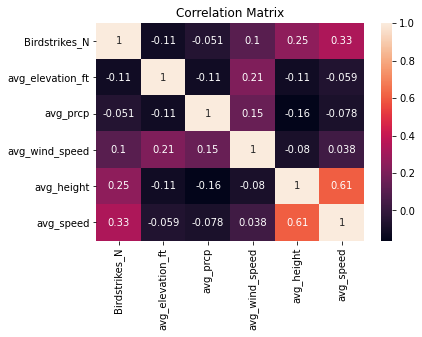

In [144]:
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

**Kmeans Cluster Analysis**

In [147]:
df_clust = df_corr
df_clust = df_clust.drop('Airport ID', axis = 1)

In [145]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

In [148]:
cluster_method = {}

for init_method in ['random','k-means++','pca']:
    sq_dists = []
    for no_of_clusters in range(2,6):
        if init_method == 'pca':
            pca = PCA(n_components=no_of_clusters).fit(scale(df_clust))
            estimator = KMeans(init=pca.components_, n_clusters=no_of_clusters)
        else:
            estimator = KMeans(init=init_method, n_clusters=no_of_clusters)
            
        df_fit = estimator.fit(scale(df_clust))
        sq_dists.append(df_fit.inertia_)
    cluster_method[init_method] = sq_dists

cluster_method["no_of_clusters"] = list(range(2,6))
    

print(pd.DataFrame(cluster_method))

        random    k-means++          pca  no_of_clusters
0  7596.227805  7596.227805  7596.227805               2
1  6273.080153  6273.080153  6496.066098               3
2  5288.324270  5288.324270  5288.324270               4
3  4457.189073  4457.189073  4542.680377               5


C:\Users\abc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\abc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\abc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\abc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


<AxesSubplot:xlabel='no_of_clusters'>

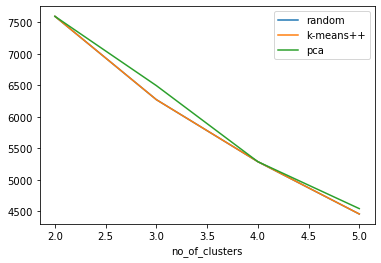

In [165]:
pd.DataFrame(cluster_method).set_index(pd.Index(range(2,6))).plot(x='no_of_clusters')

In [191]:
def draw_cluster_plot(df_clust, estimator, figsize=(20,40), cmap_name='viridis'):
    cmap = plt.cm.get_cmap(cmap_name)
    xy_toplot = list(combinations(df_clust.columns,2))
    fig, axes = plt.subplots(nrows=len(xy_toplot)//2,ncols=2, figsize=figsize)
    i = 0
    for x_ax, y_ax in xy_toplot:
        df_clust.plot.scatter(x=x_ax, y=y_ax, c=estimator.labels_, cmap=cmap, ax=axes[i//2, i%2],colorbar=False)
        i += 1
    plt.show()
    

def fit_kmeans(df_clust, num_clusters, init_method):
    if init_method == 'pca':
        pca = PCA(n_components=num_clusters).fit(df_clust)
        estimator = KMeans(init=pca.components_, n_clusters=num_clusters)
    else:
        estimator = KMeans(init=init_method, n_clusters=num_clusters)
    
    estimator.fit(df_clust)
    return estimator

In [189]:
# def draw_cluster_plot(df_clust, estimator, figsize=(20,40), cmap_name='viridis'):
#     cmap = plt.cm.get_cmap(cmap_name)
#     fig, axes = plt.subplots(nrows  =len(xy_toplot)//2 + 1, ncols=2, figsize=(15, 30))
#     i = 0
#     for x_ax, y_ax in xy_toplot:
#         if i < 13:
#             df_clust.plot.scatter(x=x_ax,
#                                  y=y_ax, 
#                                  c=estimator.labels_, 
#                                  cmap=cmap, 
#                                  ax=axes[i//2, i%2],
#                                  colorbar=False)
#         else:
#             df_clust.plot.scatter(x=x_ax,
#                          y=y_ax, 
#                          c=estimator.labels_, 
#                          cmap=cmap, 
#                          ax=axes[7, 0],
#                          colorbar=False)
#     i += 1
# plt.show()

IndexError: index 7 is out of bounds for axis 0 with size 7

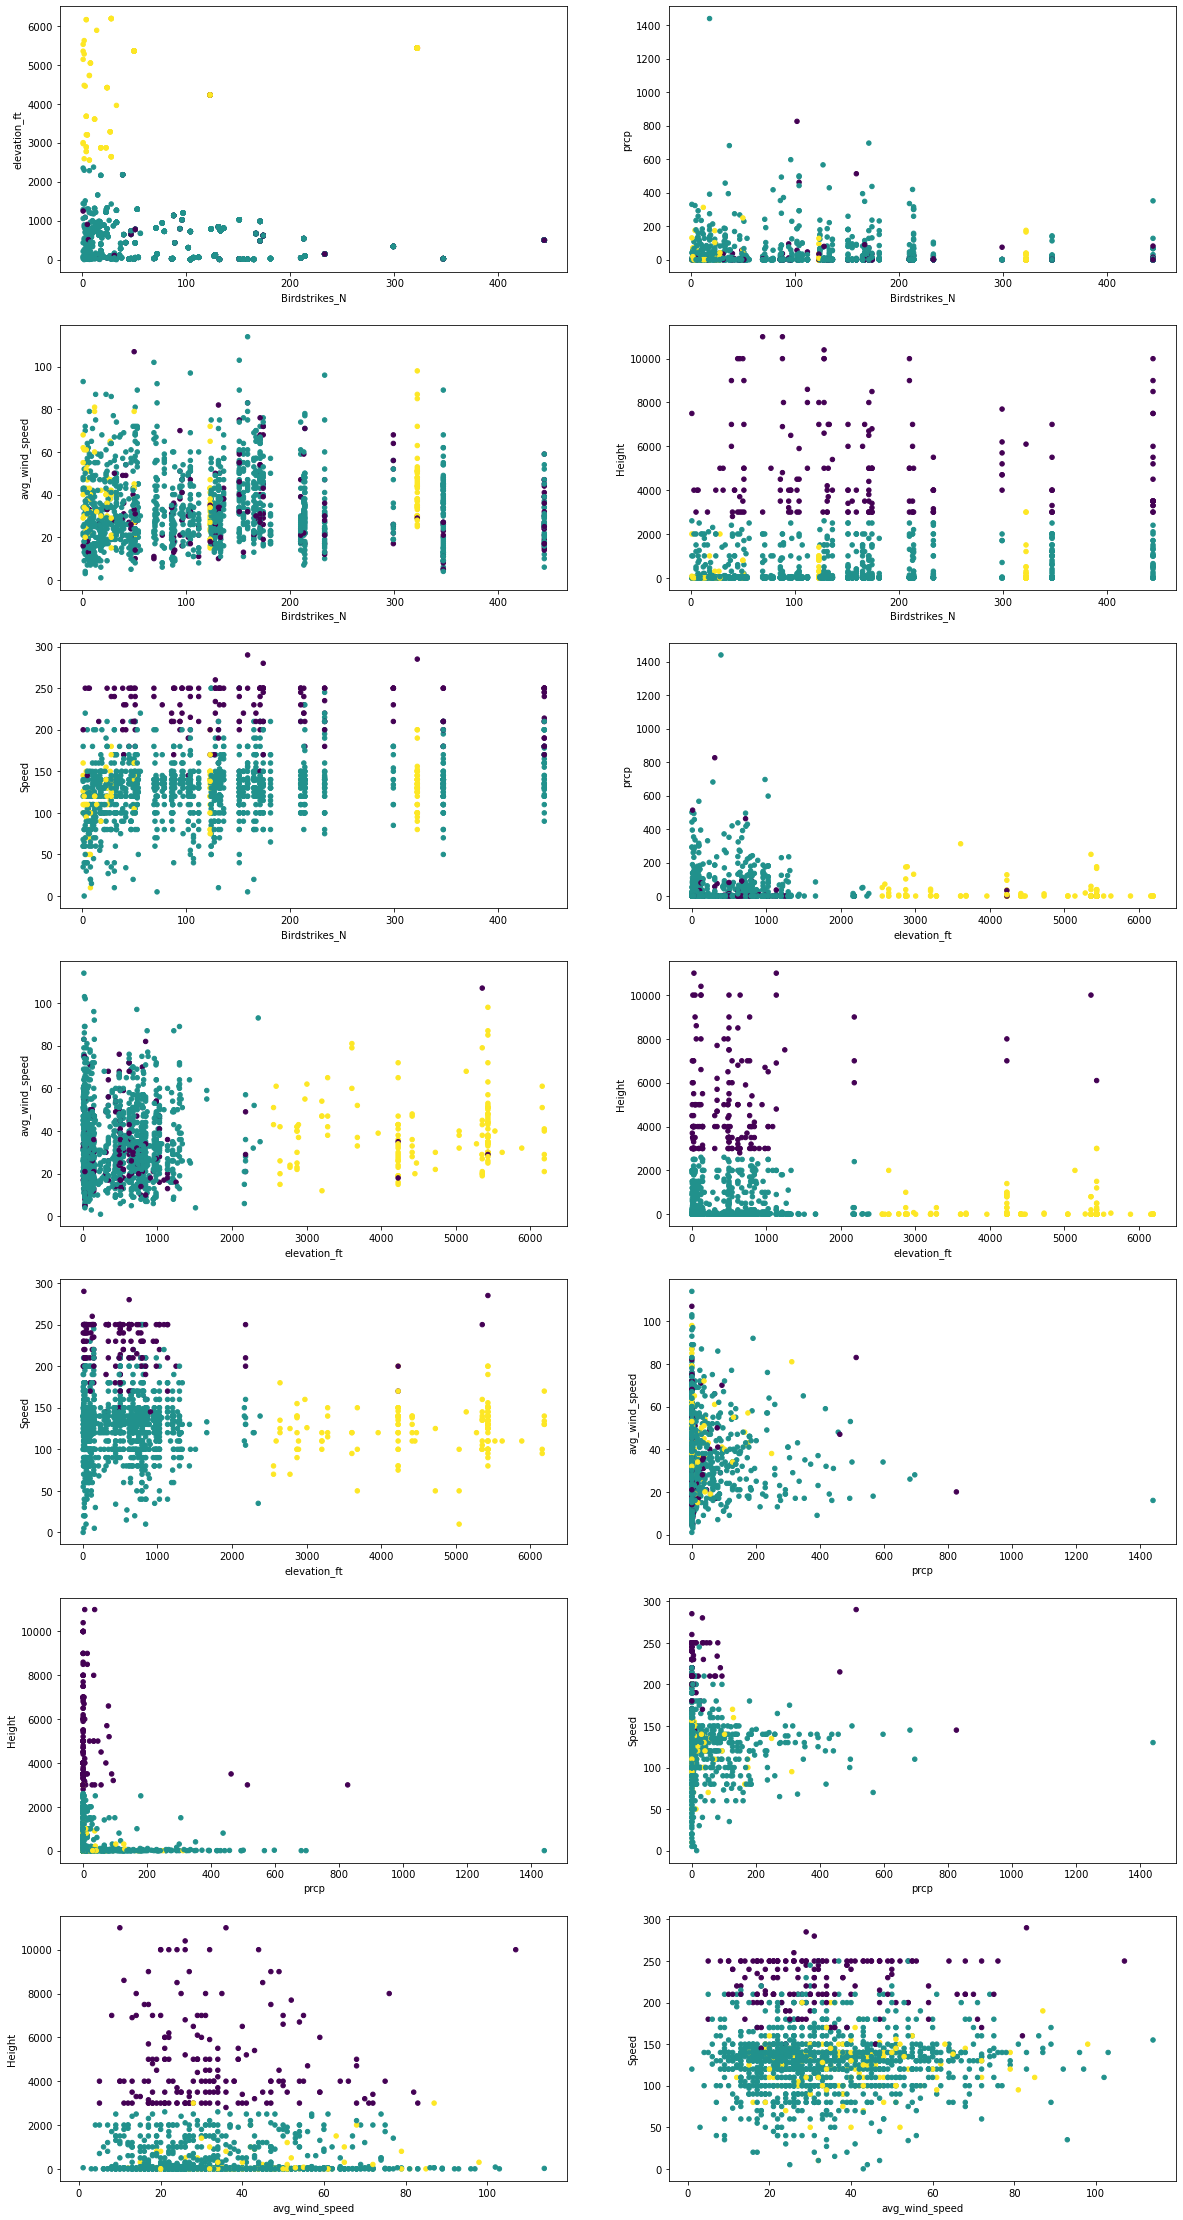

In [192]:
estimator = fit_kmeans(df_clust, 3, 'k-means++')
#centers = pd.DataFrame(estimator.cluster_centers_)
#centers.columns = df_clust.columns
#ax = sn.heatmap(centers, annot=True, cmap='Blues')
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.show()
draw_cluster_plot(df_clust, estimator)

In [136]:
df_final

,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Airport ID,Airport,State,Flight Phase,Visibility,avg_height,avg_speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,incident_date,Birdstrikes_N,name,avg_elevation_ft,municipality,coordinates,long,lat,zipcode,incident_date,avg_prcp,avg_wind_speed
0,2010,1,1,BUS,BUSINESS,C-310,KPMP,POMPANO BEACH AIRPARK,FL,TAKEOFF RUN,DAY,0.0,30.0,0.00,NE1,GULL,1,ABORTED TAKEOFF,2010-01-01,4,Pompano Beach Airpark,19.0,Pompano Beach,"-80.111099243164, 26.247100830078",-80.111099243164,26.247100830078,33060,2010-01-01,23,41
1,2010,1,1,JBU,JETBLUE AIRWAYS,A-320,KMCO,ORLANDO INTL,FL,TAKEOFF RUN,DAY,0.0,120.0,0.00,ZT3,GRACKLE,1,NONE,2010-01-01,214,Orlando International Airport,96.0,Orlando,"-81.30899810791016, 28.429399490356445",-81.30899810791016,28.429399490356445,32827,2010-01-01,150,38
2,2010,1,2,SWA,SOUTHWEST AIRLINES,B-737-700,KPDX,PORTLAND INTL (OR),OR,APPROACH,NIGHT,700.0,140.0,2.00,J21,DUCK,1,NONE,2010-01-02,69,Portland International Airport,31.0,Portland,"-122.5979996, 45.58869934",-122.5979996,45.58869934,97218,2010-01-02,0,37
3,2010,1,2,NWA,NORTHWEST AIRLINES,DC-9,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,MD,TAKEOFF RUN,DAY,0.0,140.0,0.00,K33,HAWK,1,NONE,2010-01-02,233,Baltimore/Washington International Thurgood Ma...,146.0,Baltimore,"-76.668297, 39.1754",-76.668297,39.1754,21240,2010-01-02,0,96
4,2010,1,2,SKW,SKYWEST AIRLINES,CRJ100/200,KSLC,SALT LAKE CITY INTL,UT,LANDING ROLL,DAY,0.0,80.0,0.00,YH004,HORNED LARK,1,NONE,2010-01-02,123,Salt Lake City International Airport,4227.0,Salt Lake City,"-111.97799682617188, 40.78839874267578",-111.97799682617188,40.78839874267578,84116,2010-01-02,10,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,2010,12,30,SWA,SOUTHWEST AIRLINES,B-737-300,KRSW,SOUTHWEST FLORIDA INTL ARPT,FL,CLIMB,DAY,200.0,170.0,0.00,YI010,TREE SWALLOW,1,NONE,2010-12-30,181,Southwest Florida International Airport,30.0,Fort Myers,"-81.75520324707031, 26.53619956970215",-81.75520324707031,26.53619956970215,33913,2010-12-30,0,30
1623,2010,12,30,AWE,US AIRWAYS,CRJ100/200,KBTR,"BATON ROUGE METROPOLITAN, RYAN FIELD",LA,LANDING ROLL,NIGHT,0.0,130.0,0.00,N5111,KILLDEER,1,NONE,2010-12-30,21,Baton Rouge Metropolitan Airport,70.0,Baton Rouge,"-91.149597, 30.533199",-91.149597,30.533199,70807,2010-12-30,30,47
1624,2010,12,30,COA,CONTINENTAL AIRLINES,B-737-700,KLGA,LA GUARDIA ARPT,NY,APPROACH,NIGHT,200.0,145.0,0.25,NE101,HERRING GULL,1,NONE,2010-12-30,151,La Guardia Airport,21.0,New York,"-73.872597, 40.777199",-73.872597,40.777199,11371,2010-12-30,0,24
1625,2010,12,31,SWA,SOUTHWEST AIRLINES,B-737-700,KDEN,DENVER INTL AIRPORT,CO,LANDING ROLL,DUSK,0.0,140.0,0.00,UNKBS,UNKNOWN SMALL BIRD,1,NONE,2010-12-31,322,Denver International Airport,5431.0,Denver,"-104.672996521, 39.861698150635",-104.672996521,39.861698150635,80249,2010-12-31,30,50


# References

1) https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf \
2) https://www.ncdc.noaa.gov/cdo-web/ \
3) https://www.bigdatacloud.com/geocoding-apis